# Imports 

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt 
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_ubyte
from skimage import exposure
import skimage.morphology as morp
from skimage.filters import rank
from skimage.io import imsave, imread 

In [2]:
path = "vallee.png" 

In [3]:
img = cv2.imread(path)

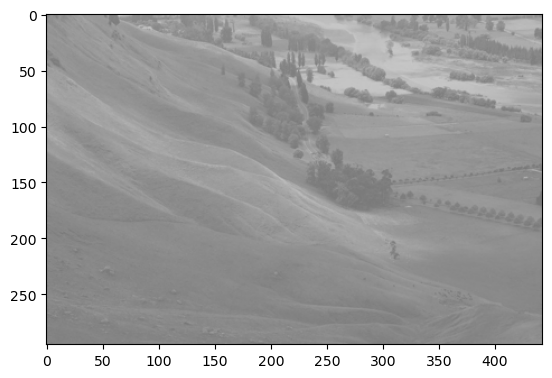

In [4]:
plt.imshow(img)
plt.show() 

In [5]:
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum() 

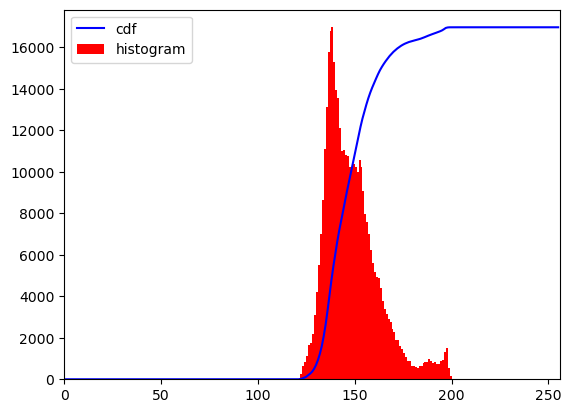

In [6]:
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r') 
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show() 

In [7]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [8]:
equ = cv2.equalizeHist(img) 

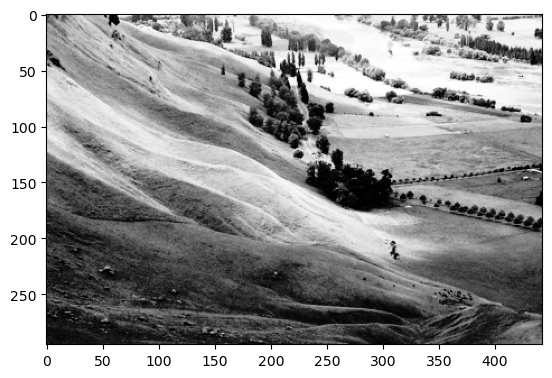

In [9]:
plt.imshow(equ,cmap="gray", vmin=0, vmax=255)
plt.show() 

In [10]:
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum() 

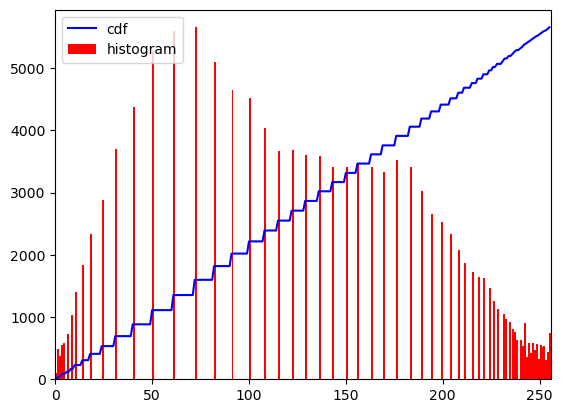

In [11]:
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r') 
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show() 

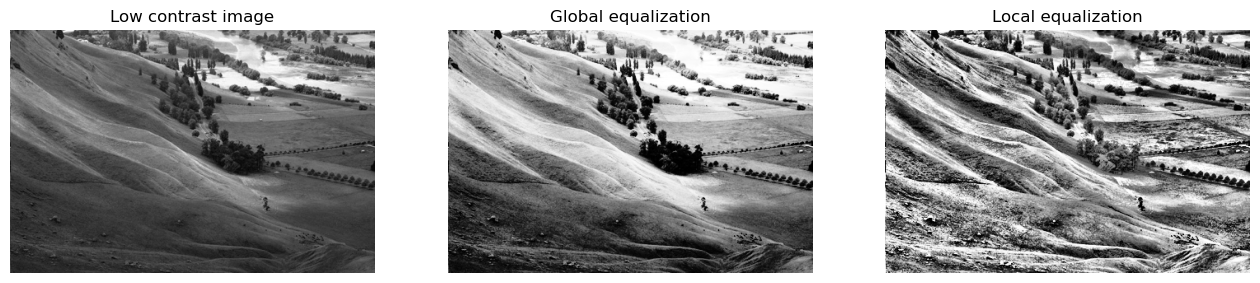

In [12]:
path = "vallee.png"  
img = img_as_ubyte(imread(path, as_gray=True))  
 
img_global = exposure.equalize_hist(img)  

kernel = morp.disk(30)  
img_local = rank.equalize(img, footprint=kernel)  
plt.rcParams['figure.figsize'] = [16, 16]  
fig, (ax_img, ax_global, ax_local) = plt.subplots(1, 3)  
ax_img.imshow(img, cmap=plt.cm.gray)  
ax_img.set_title('Low contrast image')  
ax_img.set_axis_off()  
ax_global.imshow(img_global, cmap=plt.cm.gray)  
ax_global.set_title('Global equalization')  
ax_global.set_axis_off()  
ax_local.imshow(img_local, cmap=plt.cm.gray)  
ax_local.set_title('Local equalization')  
ax_local.set_axis_off()  
plt.show()

# ---Medical image enhancement based on histogram algorithms--- 

# Original image loading : 

In [13]:
path = "416_left.jpg" 

In [14]:
img = cv2.imread(path)

In [15]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Histogram equalization, HE 

## apply_HE

In [16]:
def apply_HE(image):
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    
    M, N = image.shape
    L = 256  
    #appliquer la transformation
    transformation_function = np.floor((L-1) * (cdf / (M * N)))

    image_equalized = transformation_function[image.flatten()].reshape(image.shape)

    return image_equalized

In [17]:
img_he =  apply_HE(img)

In [18]:
M, N = img.shape[:2]  
L = 256  

## Display_result

In [19]:
def display_result(img, img_eq):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Image Originale")
    
    plt.subplot(2, 2, 2)
    hist, bins = np.histogram(img.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    plt.plot(cdf_normalized, color='b')
    plt.hist(img.flatten(), 256, [0,256], color='r')
    plt.title("Histogramme & CDF Originaux")
    
    plt.subplot(2, 2, 3)
    plt.imshow(img_eq, cmap='gray')
    plt.title("Image Égalisée")
    
    plt.subplot(2, 2, 4)
    hist_eq, bins_eq = np.histogram(img_eq.flatten(), 256, [0,256])
    cdf_eq = hist_eq.cumsum()
    cdf_normalized_eq = cdf_eq * hist_eq.max() / cdf_eq.max()
    plt.plot(cdf_normalized_eq, color='b')
    plt.hist(img_eq.flatten(), 256, [0,256], color='r')
    plt.title("Histogramme & CDF Égalisés")
    
    plt.tight_layout()
    plt.show()

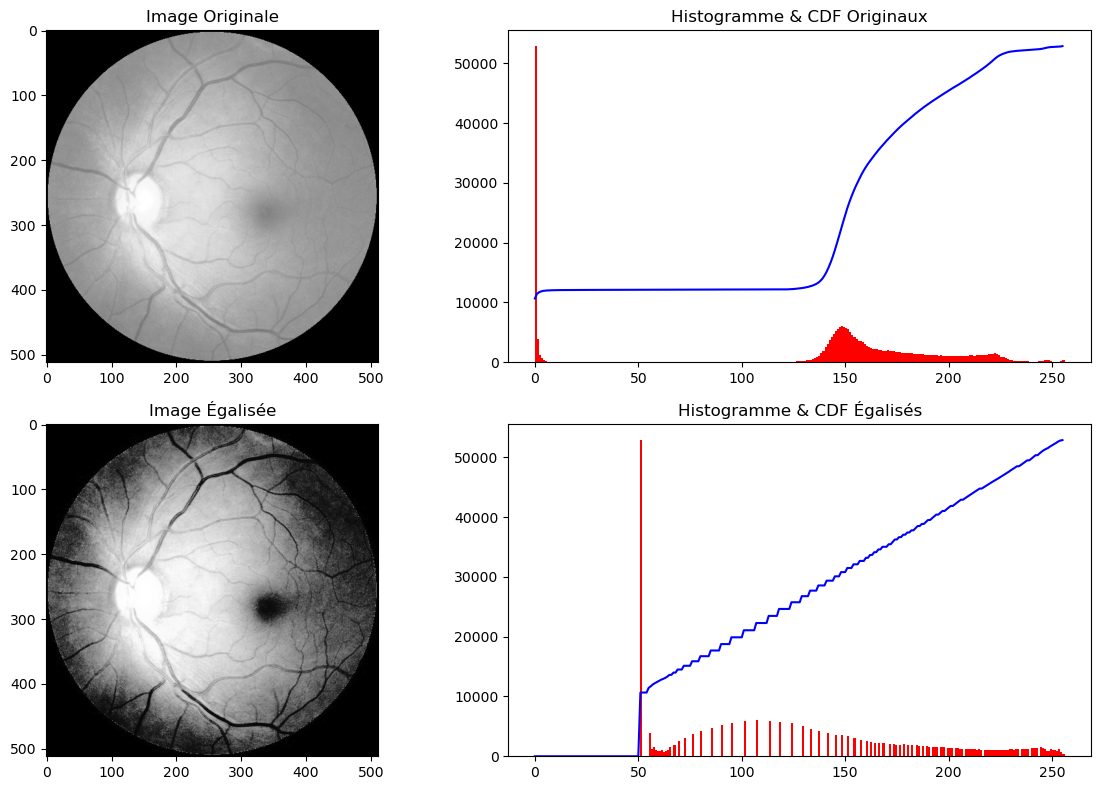

In [20]:
display_result(img, img_he)

## Interpretation 

L'application de la méthode d'égalisation d'histogramme (HE) sur l'image a transformé l'histogramme original en un histogramme égalisé où la distribution des intensités est plus uniforme sur toute la gamme.

# Cumulative histogram equalization, CHE 

## apply_CHE 

In [21]:
def apply_CHE(img):
    hist, bins = np.histogram(img.flatten(), 256, [0,256])
    cdf = hist.cumsum() 
    
    cdf_min = cdf[np.nonzero(cdf)].min() 
    
    MN = img.size 
    L = 256 
    cdf_normalized = (cdf - cdf_min) / (MN - cdf_min) * (L - 1)
    img_eq_che = np.round(cdf_normalized).astype('uint8')[img] 
    return img_eq_che

In [22]:
img_eq_che =  apply_CHE(img)

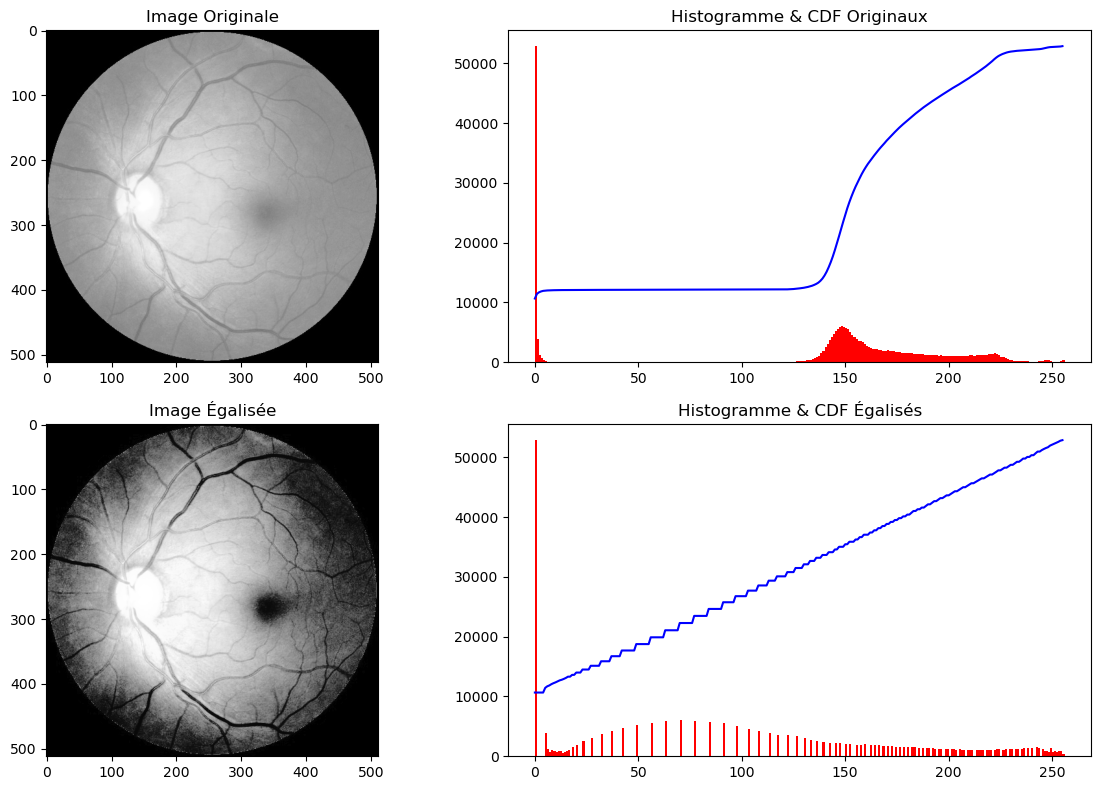

In [23]:
display_result(img, img_eq_che)

## Interpretation

La méthode CHE a ajusté l'histogramme de l'image, étalant les valeurs des pixels pour améliorer le contraste général. Cette méthode évite d'accentuer les contrastes extrêmes, comme le montre la courbe CDF qui commence à augmenter plus graduellement autour de l'intensité 50, reflétant une distribution plus homogène des valeurs de pixels après égalisation.

# Quadratic dynamic histogram equalization, QDHE :

## apply_QDHE

In [24]:
def apply_QDHE(image):
    num_bins=256
    hist, bins = np.histogram(image.flatten(), num_bins, [0, num_bins])
    
    sub_hist_limits = np.linspace(0, num_bins, 4)  # Example for 4 sub-histograms

    
    clip_limit = 0.01  # 1% of the max value as the clip limit
    clipped_hist = np.clip(hist, 0, clip_limit * np.max(hist))

  
    new_gray_levels = np.linspace(0, num_bins-1, len(sub_hist_limits))

    cdf = clipped_hist.cumsum()
    cdf_normalized = cdf * (new_gray_levels[-1] / cdf.max())
    equalized_image = np.interp(image.flatten(), bins[:-1], cdf_normalized)
    
    return equalized_image.reshape(image.shape)

In [25]:
def apply_clipping(histogram, clip_limit):
    clipped_histogram = np.clip(histogram, 0, clip_limit)
    excess = int(np.sum(histogram - clipped_histogram))
    redistribute = excess // 256
    clipped_histogram += redistribute
    excess -= redistribute * 256
    for i in range(excess):
        clipped_histogram[i % 256] += 1
    return clipped_histogram

def calculate_dynamic_ranges(cdf, m1, m2, m3):
    L = 256
    total_pixels = cdf[-1]
    spans = [m1, m2 - m1, m3 - m2, total_pixels - m3]
    range_starts = np.zeros(4, dtype=int)
    range_ends = np.zeros(4, dtype=int)
    sum_spans = sum(spans)
    for i in range(4):
        range_i = (L - 1) * spans[i] // sum_spans
        range_starts[i] = range_ends[i-1] + 1 if i > 0 else 0
        range_ends[i] = range_starts[i] + range_i
    return range_starts, range_ends

In [26]:
img_qdhe =  apply_QDHE(img)

## Display_result 

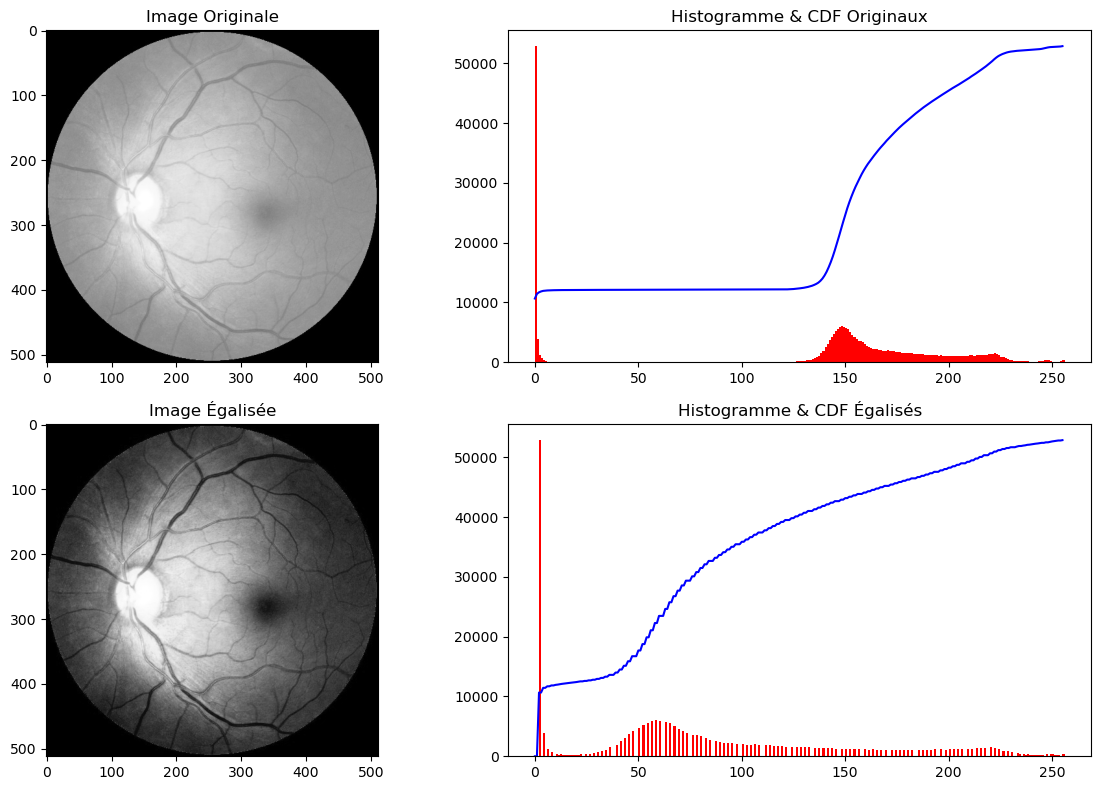

In [27]:
display_result(img, img_qdhe)

## Interpretation : 

Ce processus implique la division de l'histogramme en sous-histogrammes, ici quatre, et l'application d'un seuil de limitation (clip limit) pour contrôler l'amplification du contraste dans chaque sous-histogramme. Dans l'image résultante, nous pouvons observer que le contraste est rehaussé de façon dynamique, ce qui se traduit par un histogramme égalisé avec une courbe de distribution cumulée (CDF) qui s'étend de manière plus uniforme sur toute la gamme des niveaux de gris. Cela suggère que la méthode a permis une meilleure répartition de l'éclairage et des détails dans l'image, sans suramplifier les zones déjà bien contrastées.

# Contrast limited adaptive histogram equalization, CLAHE 

## apply_CLQHE

In [28]:
def apply_CLAHE(image, clip_limit=40, grid_size=(8, 8)):
   
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    clahe_img = clahe.apply(image)
    return clahe_img

def clip_limit(M, N, alpha, Smax):
    beta = (1 + (alpha / 100)) * (M * N / Smax) - 1
    return beta

In [29]:
clip_factor = 3 
Smax = 256  
M, N = img.shape[:2]  

In [30]:
clip_limit = clip_limit(M, N, clip_factor, Smax)
clahe_img = apply_CLAHE(img, clip_limit=clip_limit, grid_size=(8, 8))

## Display result  

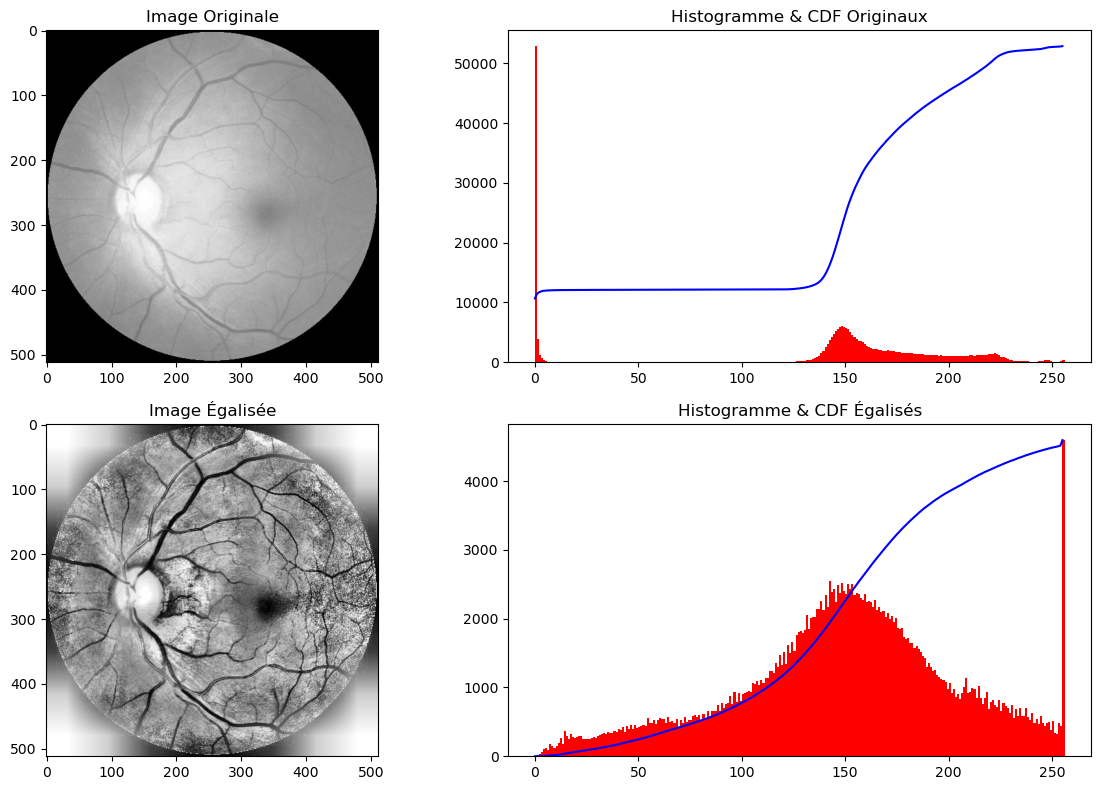

In [31]:
display_result(img, clahe_img)

## Interpration : 

CLAHE a significativement amélioré le contraste en tenant compte des variations locales de luminosité. Ce processus est accompli en divisant l'image en tuiles et en appliquant une égalisation d'histogramme à chacune d'elles avec une limite de contraste spécifiée. Le résultat est une image où les détails sont mieux définis et où les structures sont plus visibles.

# Displays all results 

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def display_multiple_results(img, list_img_eq, list_titles):
    total_plots = len(list_img_eq) * 2 + 2  # +2 pour l'image originale et son histogramme/CDF
    
    plt.figure(figsize=(10, 5 * len(list_img_eq) + 5))  # Ajuster la hauteur de la figure

    plt.subplot(len(list_img_eq) + 1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(len(list_img_eq) + 1, 2, 2)
    hist_orig, bins = np.histogram(img.flatten(), 256, [0, 256])
    cdf_orig = hist_orig.cumsum()
    cdf_normalized = cdf_orig * hist_orig.max() / cdf_orig.max()
    plt.plot(cdf_normalized, color='b')
    plt.hist(img.flatten(), 256, [0, 256], color='r')
    plt.title("Histogramme & CDF Originaux")

    for i, (img_eq, title) in enumerate(zip(list_img_eq, list_titles), start=1):
        # Afficher l'image égalisée
        plt.subplot(len(list_img_eq) + 1, 2, 2 * i + 1)
        plt.imshow(img_eq, cmap='gray')
        plt.title(f'{title} Image')
        plt.axis('off')

        plt.subplot(len(list_img_eq) + 1, 2, 2 * i + 2)
        hist_eq, bins_eq = np.histogram(img_eq.flatten(), 256, [0, 256])
        cdf_eq = hist_eq.cumsum()
        cdf_normalized_eq = cdf_eq * hist_eq.max() / cdf_eq.max()
        plt.plot(cdf_normalized_eq, color='b')
        plt.hist(img_eq.flatten(), 256, [0, 256], color='r')
        plt.title(f"Histogramme & CDF {title}")

    plt.tight_layout()
    plt.show()


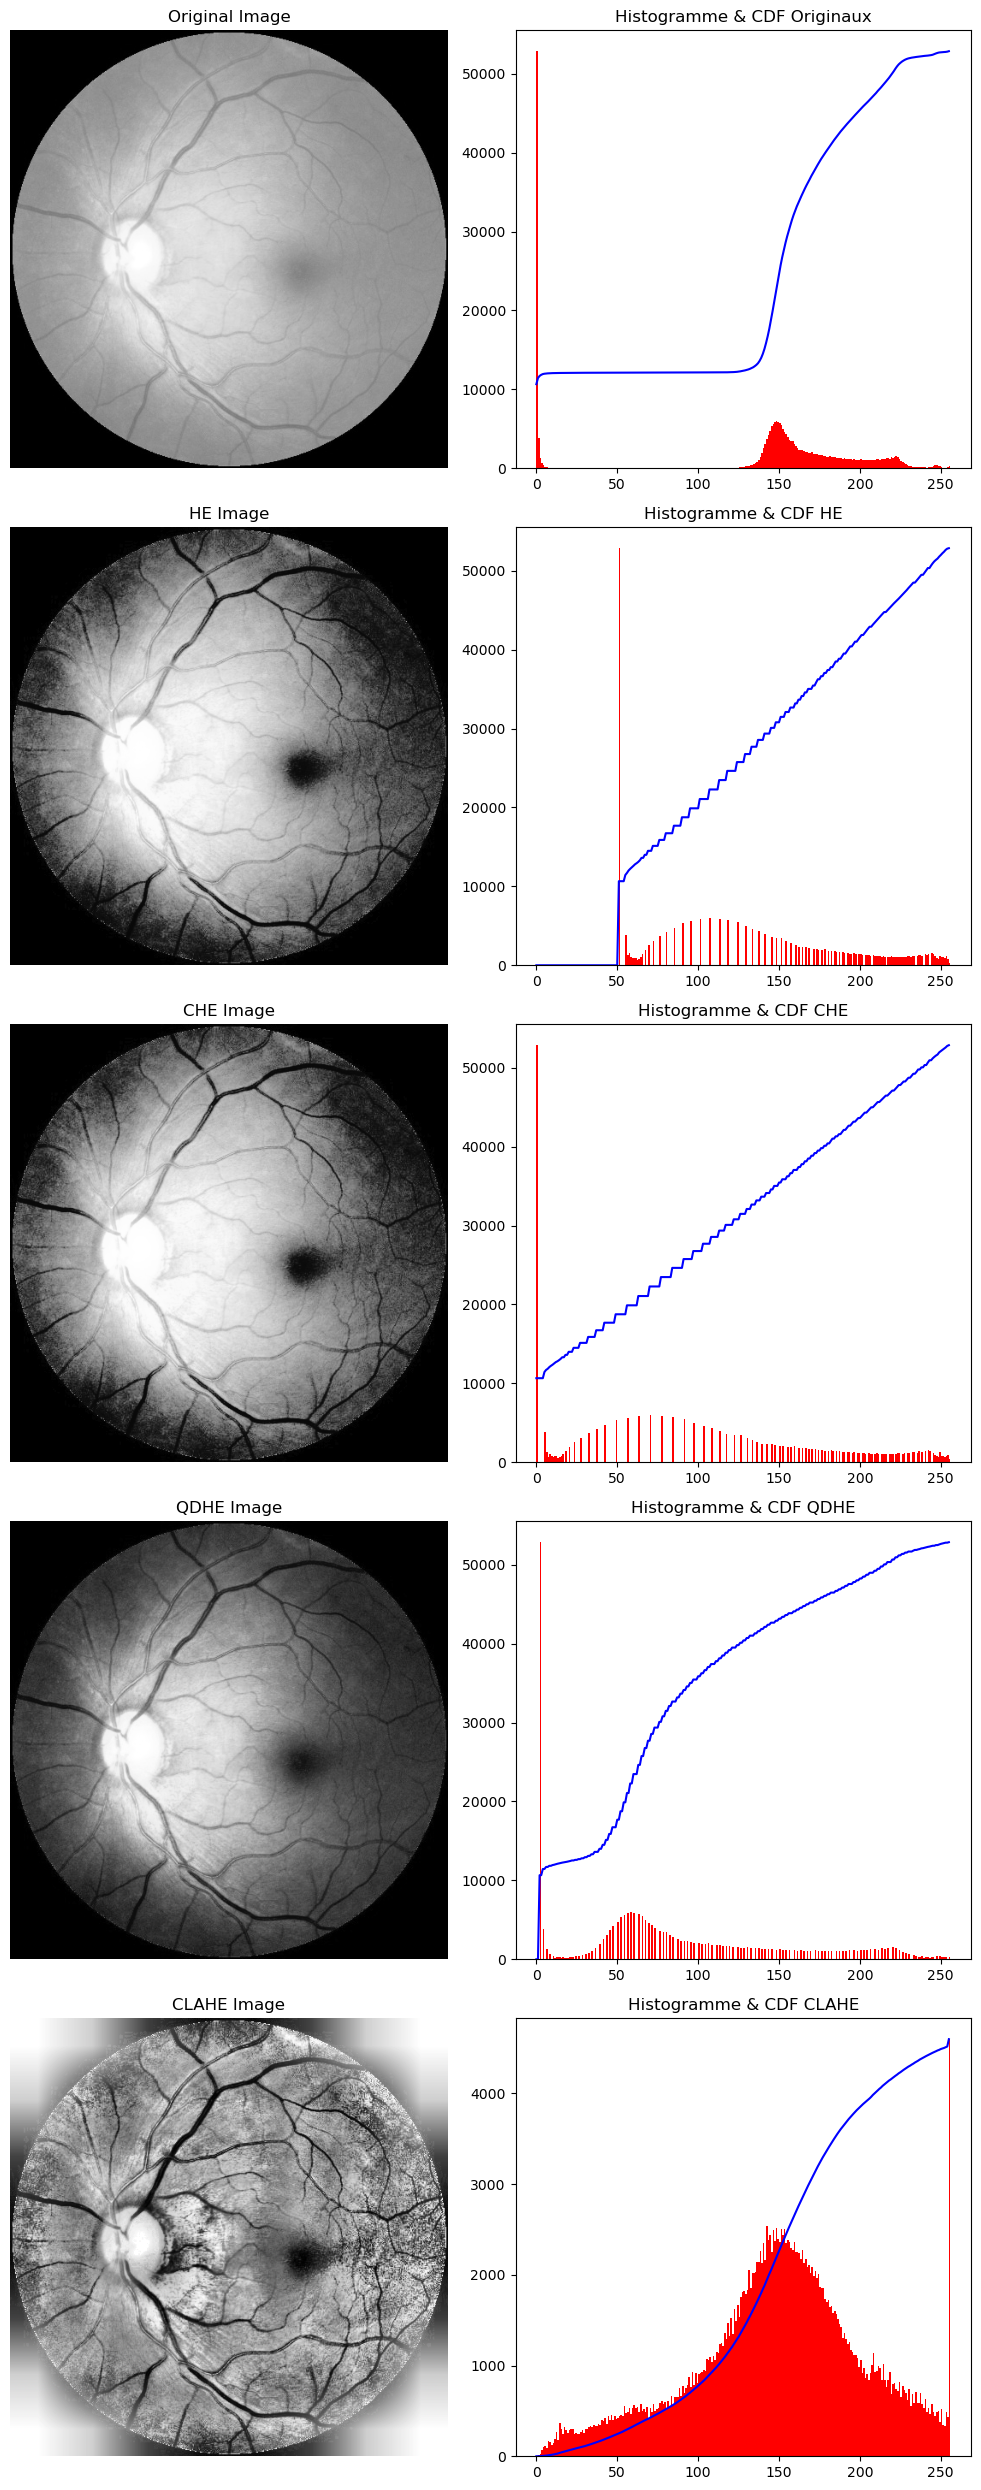

In [37]:
imgs_eq = [img_he, img_eq_che, img_qdhe, clahe_img]  
titles = ["HE", "CHE", "QDHE", "CLAHE"]  

display_multiple_results(img, imgs_eq, titles)

## Métriques de Qualité d'Image


### MSE (Mean Squared Error)
Le MSE mesure l'erreur quadratique moyenne entre l'image originale et l'image traitée. Il est calculé comme la moyenne des carrés des différences de pixels entre les deux images. Une valeur MSE plus faible indique une meilleure qualité. La formule est :
$$
\text{MSE} = \frac{1}{MN} \sum_{i=0}^{M-1}\sum_{j=0}^{N-1} [I(i, j) - K(i, j)]^2
$$
où \( I \) est l'image originale, \( K \) est l'image comparée, et \( M, N \) sont les dimensions de l'image.

### PSNR (Peak Signal-to-Noise Ratio)
Le PSNR est une mesure de la qualité de l'image ou du rapport signal-sur-bruit de crête. Il est dérivé du MSE, exprimé en décibels, et est utilisé pour mesurer la qualité de reconstruction des images compressées. Des valeurs PSNR plus élevées indiquent une meilleure qualité. La formule est :
$$
\text{PSNR} = 20 \cdot \log_{10}\left(\frac{\text{L-1}}{\sqrt{\text{MSE}}}\right)
$$
où \( L \) est la valeur maximale possible du pixel (souvent \( L = 255 \) pour les images de 8 bits).

### SD (Standard Deviation)
La déviation standard de l'image traitée. Elle mesure la dispersion des valeurs de pixels par rapport à la moyenne. Une SD élevée indique une plus grande variabilité des valeurs de pixels. La formule est :
$$
\text{SD} = \sqrt{\frac{1}{n-1} \sum_{k=1}^{n} (f(i,j) - \bar{X})^2}
$$
où \( f(i,j) \) sont les valeurs de pixels de l'image et \( \bar{X} \) est la moyenne de ces valeurs.


In [38]:
class ImageQualityMetrics:
    def __init__(self, original_image):
        self.original_image = original_image
        self.metrics = {}

    def calculate_mse(self, image):
        mse = np.mean((self.original_image - image) ** 2)
        return mse

    def calculate_psnr(self, image, mse=None):
        if mse is None:
            mse = self.calculate_mse(image)
        if mse == 0:
            return float('inf')
        psnr = 20 * np.log10(255 / np.sqrt(mse))
        return psnr

    def calculate_sd(self, image):
        return np.std(image)

    def compare_image(self, method_name, image):
        mse = self.calculate_mse(image)
        psnr = self.calculate_psnr(image, mse)
        sd = self.calculate_sd(image)
        self.metrics[method_name] = {'MSE': mse, 'PSNR': psnr, 'SD': sd}

    def display_metrics(self):
        print("Method   |          MSE      |         PSNR      |        SD")
        print("---------------------------------------------------------------")
        
        for method, metrics in self.metrics.items():
            print(f"{method:<8} | {metrics['MSE']:17.4f} | {metrics['PSNR']:17.4f} | {metrics['SD']:17.4f}")

    def display_metric_plots(self):
        n_groups = len(self.metrics)
        index = np.arange(n_groups)
        bar_width = 0.2

        mse_values = [metrics['MSE'] for metrics in self.metrics.values()]
        psnr_values = [metrics['PSNR'] for metrics in self.metrics.values()]
        sd_values = [metrics['SD'] for metrics in self.metrics.values()]

        fig, ax = plt.subplots()
        mse_bar = ax.bar(index, mse_values, bar_width, label='MSE')
        psnr_bar = ax.bar(index + bar_width, psnr_values, bar_width, label='PSNR')
        sd_bar = ax.bar(index + 2*bar_width, sd_values, bar_width, label='SD')

        ax.set_xlabel('Method')
        ax.set_title('Image Quality Metrics Comparison')
        ax.set_xticks(index + bar_width)
        ax.set_xticklabels(self.metrics.keys())
        ax.legend()

        plt.tight_layout()
        plt.show()

In [39]:
original_image = cv2.imread('416_left.jpg', cv2.IMREAD_GRAYSCALE)

iqm = ImageQualityMetrics(original_image)

equalized_images = {
    "HE": apply_HE(original_image),
    "CHE": apply_CHE(original_image),
    "QDHE": apply_QDHE(original_image),
    "CLAHE": apply_CLAHE(original_image)
}

for method, image in equalized_images.items():
    iqm.compare_image(method, image)

iqm.display_metrics()

Method   |          MSE      |         PSNR      |        SD
---------------------------------------------------------------
HE       |         1528.8774 |           16.2871 |           65.7476
CHE      |           69.5828 |           29.7058 |           83.5541
QDHE     |         3966.7030 |           12.1465 |           68.3369
CLAHE    |          109.7224 |           27.7279 |           58.3457


# Interpretation  

Les métriques indiquent que **CHE (Contrast Limited Histogram Equalization)** offre les meilleures performances en termes de fidélité à l'image originale avec le MSE le plus bas et une qualité perçue élevée avec le PSNR le plus haut. 

Cependant, visuellement, le CLAHE (Contrast Limited Adaptive Histogram Equalization) se distingue comme la méthode la plus performante. Malgré un MSE et un PSNR intermédiaires, **le CLAHE parvient à préserver les détails originaux et à améliorer la netteté de l'image de manière plus naturelle.**

Cette différence visuelle s'explique par l'approche adaptative du CLAHE qui ajuste le contraste localement en fonction des caractéristiques spécifiques de chaque zone de l'image. Contrairement à une méthode globale comme le HE qui applique le même degré d'amélioration du contraste sur toute l'image, le CLAHE évite de renforcer le bruit et de perdre des détails dans les zones claires et sombres. **Ce compromis entre amélioration du contraste et préservation des détails fait du CLAHE une méthode de choix, surtout lorsque l'objectif est d'améliorer la qualité visuelle sans sacrifier les subtilités de l'image originale.**